## Initial Tests of DMC on 1D system (Importance Sampling)


In [1]:
using Pkg


# Project env
Pkg.activate("/Users/ismaelchona/PersonalProjects/DMC_project")
Pkg.instantiate()


# Now bring them into scope (safe if they were loaded above)
using System1D
using Plots
using StatsBase
using KernelDensity
using Statistics
using Random
using Printf

# Helpers for snapshot -> 1D x and tau -> snapshot index
xs_from_snapshot(snap) = [R[1] for R in snap]

function snap_index_from_tau(tau::Real, dt::Real, nsnaps::Int)
    return clamp(Int(round(tau/dt)) + 1, 1, nsnaps)
end

# Notebook convenience RNG
const NB_RNG = MersenneTwister(42)

@info "Preamble complete - if you installed packages, restart the kernel and re-run this cell."


  Activating project at `~/PersonalProjects/DMC_project`
┌ Info: Preamble complete - if you installed packages, restart the kernel and re-run this cell.
└ @ Main /Users/ismaelchona/PersonalProjects/DMC_project/Notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:28


# 1D harmonic oscillator (importance sampling)
We aim to solve the harmonic oscillator in 1D using atomic units, $\hbar = \omega = 1$.

$$\displaystyle H = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2} x^2$$


In [2]:
# System setup (importance sampling)
H = Hamiltonian(1, 0.5, R -> 0.5 * sum(R .^ 2))   # N=1, D=0.5, V(R)= 0.5 * x^2

# Reduced sizes for a faster notebook run.
N = 2 * 10^4
W = [Walker([2*rand(NB_RNG) - 1]) for _ in 1:N]

# DMC params: dt, nsteps, nequil, targetN, ET0, pop_gain, branch_cap, nblocks.
p = DMCParams(0.005, 500, 100, 2 * 10^4, 0.5, 0.1, 50, 50)

alpha = 1.0  # for D=0.5 and V=0.5*x^2
trial = System1D.TrialWF(
    R -> -0.5 * alpha * R[1]^2,   # log|psi_T|
    R -> [-alpha * R[1]],         # grad log|psi_T|
    R -> -alpha                   # lapl log|psi_T|
)

guiding =  System1D.ImportanceGuiding(trial, H)
sim_is = System1D.DMCSim(H, p, W, guiding, NB_RNG)

# Run simulation
sim_is = System1D.run_simulation!(sim_is)

ET_history_is = sim_is.ET_history
population_history_is = sim_is.population_history
energy_mean_history_is = sim_is.energy_mean_history
walker_positions_history_is = sim_is.walker_positions_history


501-element Vector{Vector{Vector{Float64}}}:
 [[0.42164773468689276], [-0.8710294978033466], [-0.04431471786617003], [-0.6445813888409351], [-0.8929602250340536], [-0.3938139474124114], [-0.10484516188425008], [-0.712818283744578], [-0.5825445213636287], [-0.07472414765000535]  …  [0.17767280500278826], [-0.3225907372148695], [-0.9245818543806505], [-0.7317490703496103], [-0.6554242152629661], [0.4633827014618177], [-0.18763510397952388], [-0.6614612705388376], [-0.986527387747091], [0.0800172315590002]]
 [[0.3389279177378986], [-0.7885899770958211], [-0.017963544594662213], [-0.7307637445660908], [-1.0132635322432495], [-0.3565498471856099], [0.009135252088040224], [-0.5903773443220764], [-0.5902333721409161], [-0.13378736155058807]  …  [0.18585380198123738], [-0.5037907957281784], [-0.866438097323958], [-0.6888106166648956], [-0.7679800918982078], [0.33096200234310386], [-0.2713773609342633], [-0.7426257289526224], [-1.080201780559708], [-0.031374773123666155]]
 [[0.3067260267120395]

Now we can plot the results.


Reported IS energy (post-eq naive SEM, nequil=100):  E = 0.500000 +- 0.000000 (a.u.)


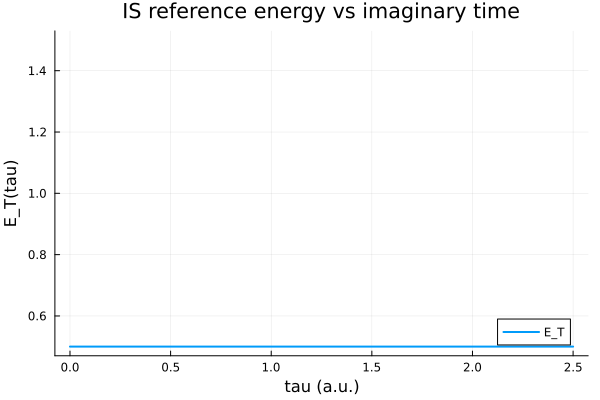

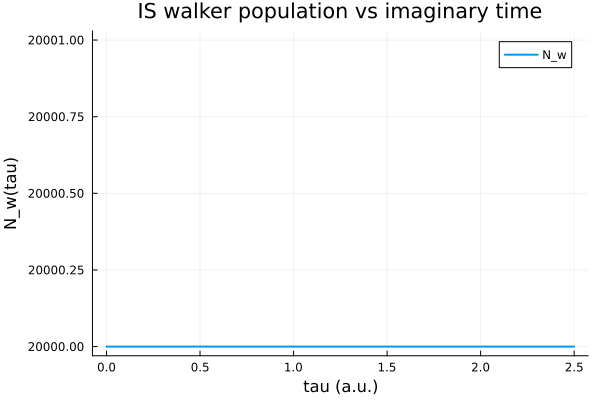

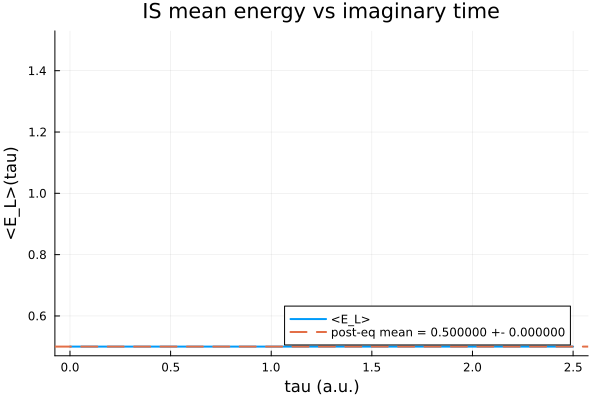

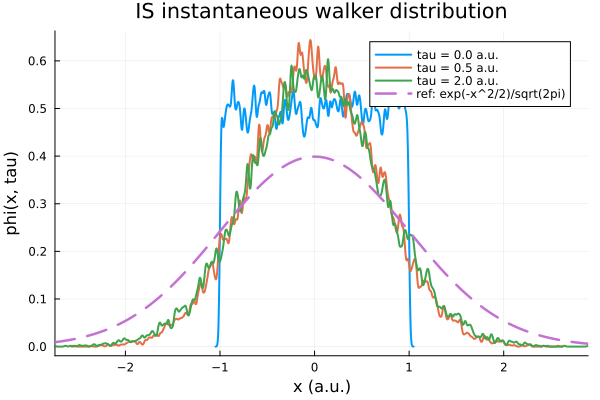

In [3]:
# Analysis and plotting
figdir = joinpath(pwd(), "figures")
mkpath(figdir)
nequil = sim_is.params.nequil
taus   = [0.0, 0.5, 2.0]

dt = sim_is.params.dt
nsnaps = length(walker_positions_history_is)

t_is = dt .* (0:(length(ET_history_is)-1))   # tau axis for time-series

# compute mean for points after nequil
start_idx = min(nequil + 1, length(energy_mean_history_is))
postE = energy_mean_history_is[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

# sig fig formatting
p10 = isfinite(SEM) && SEM>0 ? floor(Int, log10(abs(SEM))) : 0
lead = isfinite(SEM) && SEM>0 ? SEM / 10.0^p10 : 1.0
sigunc = (lead < 1.5) ? 2 : 1
decimals = isfinite(SEM) && SEM>0 ? max(0, -p10 + (sigunc - 1)) : 6

println(@sprintf("Reported IS energy (post-eq naive SEM, nequil=%d):  E = %.*f +- %.*f (a.u.)",
                 nequil, decimals, Ebar, decimals, SEM))

# ET vs tau
p1_is = plot(t_is, ET_history_is, lw=2, label="E_T",
             xlabel="tau (a.u.)", ylabel="E_T(tau)",
             title="IS reference energy vs imaginary time", legend=:bottomright)
savefig(p1_is, joinpath(figdir, "IS_ET_vs_tau.png"))
display(p1_is)

# population vs tau
p2_is = plot(t_is, population_history_is, lw=2, label="N_w",
             xlabel="tau (a.u.)", ylabel="N_w(tau)",
             title="IS walker population vs imaginary time", legend=:topright)
savefig(p2_is, joinpath(figdir, "IS_population_vs_tau.png"))
display(p2_is)

# mean energy vs tau + horizontal mean line
p3_is = plot(t_is, energy_mean_history_is, lw=2, label="<E_L>",
             xlabel="tau (a.u.)", ylabel="<E_L>(tau)",
             title="IS mean energy vs imaginary time", legend=:bottomright)
hline!(p3_is, [Ebar], ls=:dash, lw=2, label=@sprintf("post-eq mean = %.*f +- %.*f", decimals, Ebar, decimals, SEM))
savefig(p3_is, joinpath(figdir, "IS_mean_energy_vs_tau.png"))
display(p3_is)

# overlay KDE PDFs at selected tau + reference Gaussian
snap_index(tau) = clamp(Int(round(tau/dt)) + 1, 1, nsnaps)
xs(snap) = [R[1] for R in snap]

idxs = snap_index.(taus)
xs_list = [xs(walker_positions_history_is[i]) for i in idxs]

xmin = minimum(minimum.(xs_list))
xmax = maximum(maximum.(xs_list))

p_pdf_is = plot(xlabel="x (a.u.)", ylabel="phi(x, tau)",
                title="IS instantaneous walker distribution", xlims=(xmin, xmax),
                legend=:topright)

for (xvals, tau) in zip(xs_list, taus)
    k = kde(xvals; bandwidth = 0.012)
    plot!(p_pdf_is, k.x, k.density, lw=2, label="tau = $(tau) a.u.")
end

xgrid = range(xmin, xmax; length=800)
gauss = @. exp(-xgrid^2 / 2) / sqrt(2*pi)
plot!(p_pdf_is, xgrid, gauss, lw=2.5, ls=:dash, label="ref: exp(-x^2/2)/sqrt(2pi)")

savefig(p_pdf_is, joinpath(figdir, "IS_pdf_overlay_vs_tau.png"))
display(p_pdf_is)
